## Imports

In [1]:
import tensorflow as tf
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# import transformers
from transformers import TFAutoModel, AutoTokenizer

In [2]:
tf.__version__

'2.15.0'

|Datset Link|
https://www.kaggle.com/datasets/alfathterry/bbc-full-text-document-classification

In [3]:
dataframe = pd.read_csv('british_broadcasting_center_data.csv')

In [4]:
dataframe.head()

,data,labels
0,Musicians to tackle US red tape Musicians gro...,entertainment
1,"U2s desire to be number one U2, who have won ...",entertainment
2,Rocker Doherty in on-stage fight Rock singer ...,entertainment
3,Snicket tops US box office chart The film ada...,entertainment
4,"Oceans Twelve raids box office Oceans Twelve,...",entertainment


In [5]:
dataframe.isna().sum()

data      0
labels    0
dtype: int64

No null values in our dataset

## Distribution of labels

In [6]:
dataframe.labels.value_counts()

labels
sport            511
business         510
politics         417
tech             401
entertainment    386
Name: count, dtype: int64

In [7]:
sum(dataframe.labels.value_counts())

2225

In [8]:
dataframe.labels.value_counts()/sum(dataframe.labels.value_counts())*100

labels
sport            22.966292
business         22.921348
politics         18.741573
tech             18.022472
entertainment    17.348315
Name: count, dtype: float64

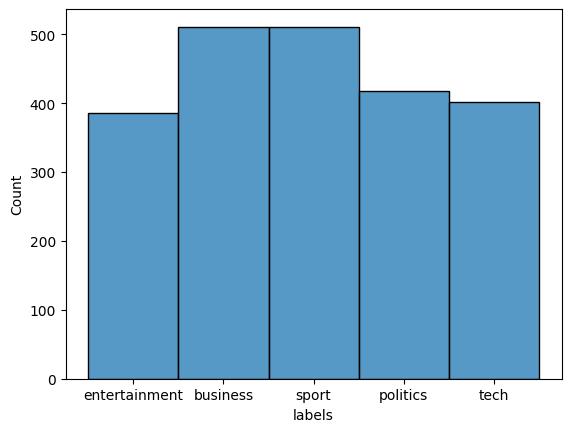

In [9]:
distrubution_labels = sns.histplot(dataframe.labels)

Our labels are pretty well distributed so we will not try to create an even dataset

## Splitting data into train and test

In [10]:
features = dataframe['data']
labels = dataframe['labels']

In [11]:
train_features, test_features, train_labels, test_labels = train_test_split(features,labels, random_state = 42, test_size = 0.33)

In [12]:
train_features.head()

1538    Blair returns from peace mission  Prime Minist...
187     Last Star Wars not for children  The sixth and...
619     UK risks breaking golden rule  The UK governme...
2000    Go-ahead for new internet names  The internet ...
158     Sideways dominates Spirit awards  The comedy S...
Name: data, dtype: object

In [13]:
train_labels.head()

1538         politics
187     entertainment
619          business
2000             tech
158     entertainment
Name: labels, dtype: object

In [14]:
train_labels.unique()

array(['politics', 'entertainment', 'business', 'tech', 'sport'],
      dtype=object)

## Finding how may words are there in a sentence

In [15]:
sentence_length = [len(sentence.split()) for sentence in train_features.to_list()]

(array([740., 523., 169.,  39.,   8.,   4.,   1.,   1.,   0.,   0.,   2.,
          0.,   0.,   1.,   1.,   0.,   0.,   0.,   0.,   1.]),
 array([ 116. ,  331.8,  547.6,  763.4,  979.2, 1195. , 1410.8, 1626.6,
        1842.4, 2058.2, 2274. , 2489.8, 2705.6, 2921.4, 3137.2, 3353. ,
        3568.8, 3784.6, 4000.4, 4216.2, 4432. ]),
 <BarContainer object of 20 artists>)

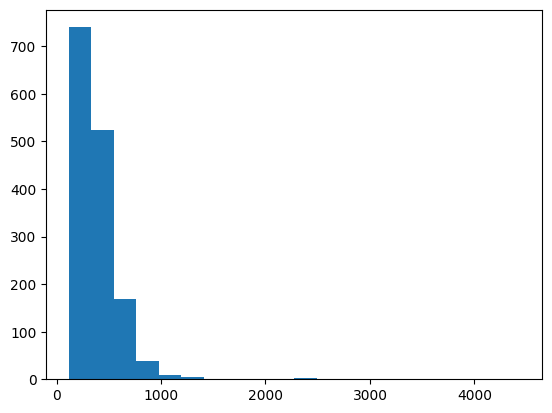

In [16]:
plt.hist(sentence_length, bins = 20)

In [17]:
# sentence_length
np.mean(sentence_length)

385.9771812080537

## Finding what sentence_length corresponds to 20 percentile of sentences.

We are going for 20 percentile as max token length is 512 from tokenizer, but 512 is too large so our gpu goes out of memory.

In [18]:
max_length = int(np.percentile(sentence_length,20))
max_length

227

We will be using 227 words from each of our sentences to be tokenized and be sent as inputs to BERT model

## Tokenizing and encoding our splits

### Tokenizing

In [19]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [20]:
train_features_encoded = tokenizer(train_features.to_list(), return_tensors = 'tf', padding = True, truncation = True, max_length = max_length)

In [21]:
# converting it top dict as there is a bug where keras recognizes dict objects \
# but not our BatchEncoding returned by the tokenizer, even though BatchEncoding is a subclass of dict.
train_features_encoded = dict(train_features_encoded)
train_features_encoded

{'input_ids': <tf.Tensor: shape=(1490, 227), dtype=int32, numpy=
 array([[  101, 10503,  5651, ...,  5082,  1999,   102],
        [  101,  2197,  2732, ..., 14957,  2232,   102],
        [  101,  2866, 10831, ...,  2917, 10035,   102],
        ...,
        [  101, 12022, 29344, ..., 12022, 29344,   102],
        [  101, 19181,  4590, ..., 21703,  1012,   102],
        [  101, 18411,  4107, ...,  4710,  2368,   102]], dtype=int32)>,
 'token_type_ids': <tf.Tensor: shape=(1490, 227), dtype=int32, numpy=
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>,
 'attention_mask': <tf.Tensor: shape=(1490, 227), dtype=int32, numpy=
 array([[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, .

In [22]:
test_features_encoded = tokenizer(test_features.to_list(), return_tensors = 'tf', padding = True, truncation = True, max_length = max_length)
test_features_encoded = dict(test_features_encoded)
test_features_encoded

{'input_ids': <tf.Tensor: shape=(735, 227), dtype=int32, numpy=
 array([[  101,  2859,  2085, ...,  1996,  2746,   102],
        [  101,  5747,  5166, ...,  3947,  2000,   102],
        [  101, 12616,  4028, ...,  4037,  4811,   102],
        ...,
        [  101,  2139,  9152, ..., 12376,  1010,   102],
        [  101,  9590,  7559, ...,  1010,  2056,   102],
        [  101,  3565,  2586, ...,   102,     0,     0]], dtype=int32)>,
 'token_type_ids': <tf.Tensor: shape=(735, 227), dtype=int32, numpy=
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>,
 'attention_mask': <tf.Tensor: shape=(735, 227), dtype=int32, numpy=
 array([[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ...,

### Encoding

In [23]:
le = LabelEncoder()

In [24]:
train_labels_encoded = le.fit_transform(train_labels.to_numpy())

In [25]:
train_labels_encoded[0]

2

In [26]:
test_labels_encoded = le.transform(test_labels.to_numpy())

In [27]:
test_labels_encoded[1]

0

### Categories

In [28]:
categories = le.classes_
categories

array(['business', 'entertainment', 'politics', 'sport', 'tech'],
      dtype=object)

In [29]:
num_categories = len(categories)
num_categories

5

## Creating a dataset

In [30]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_features_encoded, train_labels_encoded))
train_dataset_batch = train_dataset.batch(batch_size = 32).shuffle(buffer_size = 1000).prefetch(tf.data.AUTOTUNE)

In [31]:
inp,out = next(iter(train_dataset_batch))
print(inp, '\n\n', out)

{'input_ids': <tf.Tensor: shape=(32, 227), dtype=int32, numpy=
array([[  101, 23413,  2229, ...,  3003,  1010,   102],
       [  101, 10991,  3362, ...,  2042,  1999,   102],
       [  101,  3795,  2713, ...,  1998,  2605,   102],
       ...,
       [  101,  6801,  2143, ...,  1996,  2782,   102],
       [  101,  2470, 10069, ...,  4381,  1010,   102],
       [  101, 15723,  2890, ..., 13426,  2003,   102]], dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(32, 227), dtype=int32, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(32, 227), dtype=int32, numpy=
array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=int32)>}

In [32]:
test_dataset = tf.data.Dataset.from_tensor_slices((test_features_encoded, test_labels_encoded))
test_dataset_batch = test_dataset.batch(batch_size = 32).shuffle(buffer_size = 1000).prefetch(tf.data.AUTOTUNE)

## Building a Model

In [33]:
model = TFAutoModel.from_pretrained('bert-base-uncased')

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [34]:
class BERT_classifier(tf.keras.Model):
  def __init__(self, bert_model, num_categories):
    super().__init__()
    self.bert = bert_model
    self.dense = tf.keras.layers.Dense(num_categories, kernel_initializer = 'he_normal')
    self.activation = tf.keras.layers.Activation('softmax')

  def call(self,inputs):
    x = self.bert(inputs)[1]
    x = self.dense(x)
    return self.activation(x)

In [35]:
classifier = BERT_classifier(model, num_categories = 5)
classifier.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-5),
                   loss = tf.keras.losses.SparseCategoricalCrossentropy(),
                   metrics = ['accuracy']
                   )

In [36]:
history = classifier.fit(train_dataset_batch,
                        # train_features_encoded,train_labels_encoded,
                         epochs = 5,
                         validation_data = test_dataset_batch
                         )

Epoch 1/5
47/47 [==============================] - 212s 2s/step - loss: 0.9792 - accuracy: 0.6664 - val_loss: 0.3508 - val_accuracy: 0.9510
Epoch 2/5
47/47 [==============================] - 79s 2s/step - loss: 0.2160 - accuracy: 0.9644 - val_loss: 0.1316 - val_accuracy: 0.9714
Epoch 3/5
47/47 [==============================] - 80s 2s/step - loss: 0.0913 - accuracy: 0.9866 - val_loss: 0.1069 - val_accuracy: 0.9701
Epoch 4/5
47/47 [==============================] - 80s 2s/step - loss: 0.0470 - accuracy: 0.9946 - val_loss: 0.0734 - val_accuracy: 0.9796
Epoch 5/5
47/47 [==============================] - 80s 2s/step - loss: 0.0242 - accuracy: 0.9987 - val_loss: 0.0611 - val_accuracy: 0.9823


## Making an interface

In [37]:
!pip install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 48.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 12.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.6/314.6 kB 34.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.5/142.5 kB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 51.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 10.0 MB/

In [38]:
import gradio as gr

In [39]:
def classify(input_text):
  tokenized_text = tokenizer(input_text, return_tensors = 'tf', padding = True, truncation = True, max_length = 227)
  tokenized_text = dict(tokenized_text)
  prediction = classifier.predict(tokenized_text)
  result = categories[tf.argmax(prediction, axis = 1)][0]
  return result

demo = gr.Interface(
    fn=classify,
    inputs=["text"],
    outputs=["text"],
)

demo.launch(debug = True,)

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://54ac0c556f40196bca.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


1/1 [==============================] - 0s 60ms/step
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://54ac0c556f40196bca.gradio.live


### Example Text
 China now top trader with Japan  China overtook the US to become Japans biggest trading partner in 2004, according to numbers released by Japans Finance Ministry on Wednesday.  China accounted for 20.1% of Japans trade in 2004, compared with 18.6% for the US. In 2003, the US was ahead with 20.5% and China came second with 19.2%. The change highlights Chinas growing importance as an economic powerhouse. In 2004, Japans imports from and exports to China (and Hong Kong) added up to 22,201bn yen ($214.6bn;xc2xa3114.5bn). This is the highest figure for Japanese trade with China since records began in 1947. It compares with 20,479.5bn yen in trade with the US.

[Business]
 ____   
 Keanu Reevs in a new Netflix Originals

[Entertainment]
____
During the 19th over of the CSK innings, Dhoni was completely foxed by a slower delivery from Harshal Patel that dipped rapidly and left him completely flabbergasted. The ball went right through his defense and crashed into the off-stump to leave CSK and Dhoni fans shell-shocked.

This was the first time that Dhoni was dismissed by any bowler in IPL 2024 with his previous dismissal in the last match against PBKS being a run-out.

"Wicket was on drier side. I have too much respect for him to celebrate when I get him out (on Dhoni). One of the advantages of playing a day game is that the square is quite rough. So the ball starts reversing. In my first over it was reversing. It's all about the feel of that delivery (slower one). More you bowl the better you get. Most batters don't pick it. Have been practicing in the nets, and when it comes out it gives you great results," Harshal said when asked about his wicket celebration.

[Sports]
____

A new report from Microsoft outlines the steps the company took to release responsible AI platforms last year.

In its Responsible AI Transparency Report, which mainly covers 2023, Microsoft touts its achievements around safely deploying AI products. The annual AI transparency report is one of the commitments the company made after signing a voluntary agreement with the White House in July last year. Microsoft and other companies promised to establish responsible AI systems and commit to safety.

Microsoft says in the report that it created 30 responsible AI tools in the past year, grew its responsible AI team, and required teams making generative AI applications to measure and map risks throughout the development cycle. The company notes that it added Content Credentials to its image generation platforms, which puts a watermark on a photo, tagging it as made by an AI model.

[Tech]
____